### Setup

In [14]:
import numpy as np
import epios
from scipy.interpolate import interp1d, make_interp_spline
import matplotlib.pyplot as plt
import pandas as pd

### Do sampling

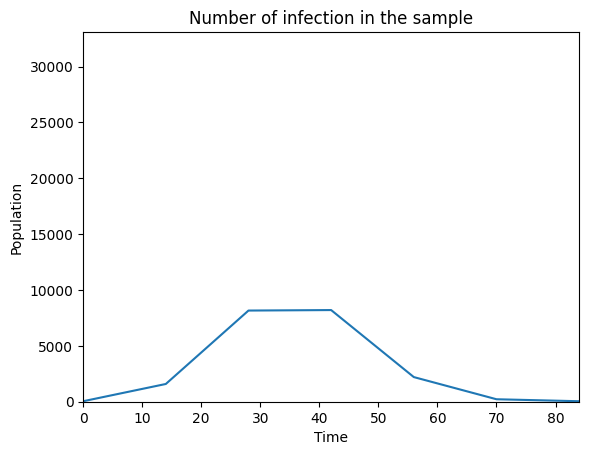

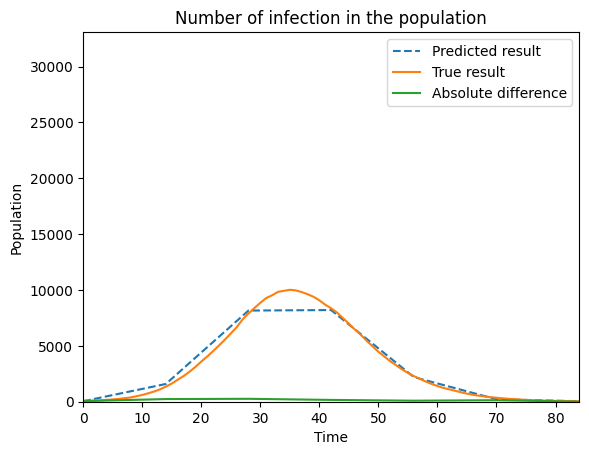

In [33]:
demo_data = pd.read_csv('./demographics_large.csv')
time_data = pd.read_csv('./inf_status_history_large.csv')

# Define the class instance
postprocess = epios.PostProcess(time_data=time_data, demo_data=demo_data)
time_sample=[0, 14, 28, 42, 56, 70, 84]

# Do prediction and comparison based age-region stratification
result, diff = postprocess.predict.AgeRegion(sample_size=750,
                                             time_sample=time_sample,
                                             comparison=True,
                                            #  non_responder=False,
                                             gen_plot=True,
                                             sample_strategy='Random')

### Interpolation

In [34]:
# This has the true result
true_result_plot = []
for t in range(max(time_sample) + 1):
    num = time_data.iloc[t, 1:].value_counts().get(3, 0)
    num += time_data.iloc[t, 1:].value_counts().get(4, 0)
    num += time_data.iloc[t, 1:].value_counts().get(5, 0)
    num += time_data.iloc[t, 1:].value_counts().get(6, 0)
    num += time_data.iloc[t, 1:].value_counts().get(7, 0)
    num += time_data.iloc[t, 1:].value_counts().get(8, 0)
    true_result_plot.append(num)

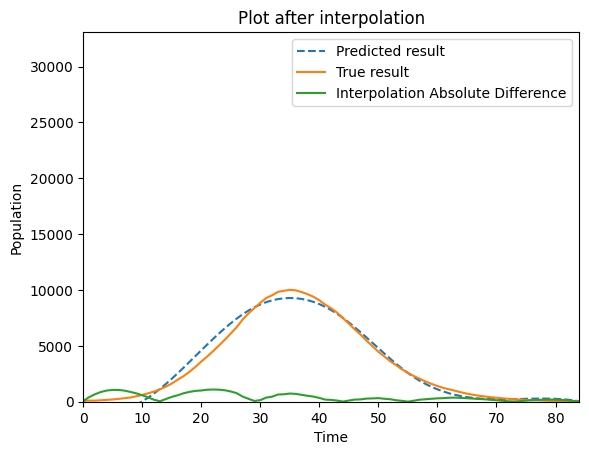

Spline Absolute Difference is 34083.940831945016
Spline Absolute Max is 1093.3188254893794


In [35]:
# Spline Interpolation
result_scaled = np.round(np.array(result[1]) * len(demo_data))
cubic_interp = interp1d(time_sample, result_scaled, kind='cubic')
y_interpolated = cubic_interp(range(max(time_sample) + 1))
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
plt.figure()
plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.xlim(0, max(time_sample))
plt.ylim(0, len(demo_data))
plt.title('Plot after interpolation')
plt.show()
score_spline_14days = np.sum(diff_interp)
max_spline_14days = max(diff_interp)
print('Spline Absolute Difference is', score_spline_14days)
print('Spline Absolute Max is', max_spline_14days)

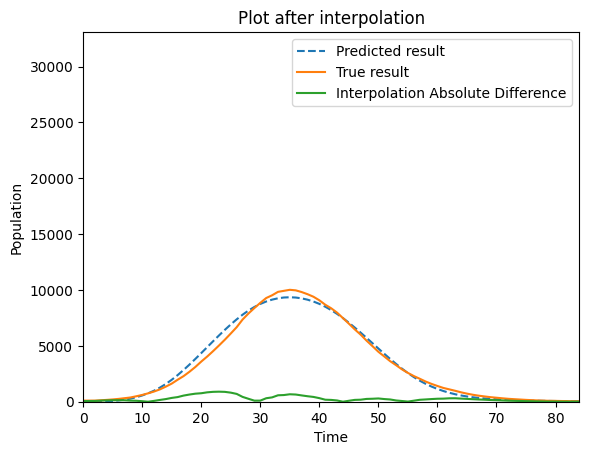

B-Spline Absolute Difference is 21970.35354339542
B-Spline Absolute Max is 898.6662928907836


In [36]:
# B-Spline Interpolation
k = 3 # Degree of the spline
spline = make_interp_spline(time_sample, result_scaled, k=k, bc_type='natural')  # Natural boundary conditions
y_interpolated = spline(range(max(time_sample) + 1))
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
plt.figure()
plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.xlim(0, max(time_sample))
plt.ylim(0, len(demo_data))
plt.title('Plot after interpolation')
plt.show()
score_bspline_14days = np.sum(diff_interp)
max_bspline_14days = max(diff_interp)
print('B-Spline Absolute Difference is', score_bspline_14days)
print('B-Spline Absolute Max is', max_bspline_14days)

### Interpolation Performance

In [ ]:
# See file ./limited_resources_parallel_comp.py